<a href="https://colab.research.google.com/github/partha1189/machine_learning/blob/timeSeries/forecasting_with_conv1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Time Series Forecasting With CNN***

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [3]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)


def trend(time, slope=0):
    return slope * time
  
  
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

  
def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)
  
  
def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

def seq2seq_window_dataset(series, window_size, batch_size = 32, shuffle_buffer = 1000):
  series = tf.expand_dims(series, axis = -1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w : (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift = 1, drop_remainder = True)
  ds = ds.flat_map(lambda w:w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

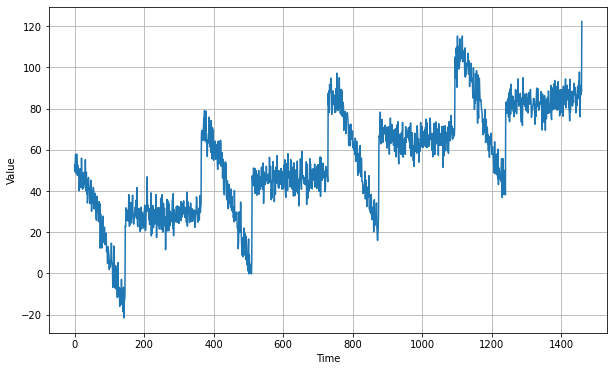

In [4]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Preprocessing with 1-D Conv Layers

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(32)

window_size = 30
train_set = seq2seq_window_dataset(series, window_size, batch_size=128)

# Hyperparameters for con-1D


*   no_of_filters
*   kernel_size
*   strides
*   padding type eg: causal(prepad zero to i/p), same




In [7]:
model = keras.models.Sequential([
   keras.layers.Conv1D(filters=32, kernel_size=5,
                       strides=1, padding='causal',
                       activation='relu',
                       input_shape=[None, 1]),
   keras.layers.LSTM(32, return_sequences=True),          
   keras.layers.LSTM(32, return_sequences=True), 
   keras.layers.Dense(1),
   keras.layers.Lambda(lambda x : x * 200)                     
])

lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch : 1e-8  * 10**(epoch/20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])
history = model.fit(train_set, epochs = 100, callbacks = [lr_schedule])

Epoch 1/100
12/12 [==============================] - 0s 11ms/step - loss: 99.3144 - mae: 99.8140
Epoch 2/100
12/12 [==============================] - 0s 9ms/step - loss: 97.4951 - mae: 97.9946
Epoch 3/100
12/12 [==============================] - 0s 10ms/step - loss: 94.4862 - mae: 94.9857
Epoch 4/100
12/12 [==============================] - 0s 9ms/step - loss: 90.5205 - mae: 91.0200
Epoch 5/100
12/12 [==============================] - 0s 9ms/step - loss: 86.0263 - mae: 86.5259
Epoch 6/100
12/12 [==============================] - 0s 9ms/step - loss: 81.8681 - mae: 82.3677
Epoch 7/100
12/12 [==============================] - 0s 11ms/step - loss: 78.4293 - mae: 78.9290
Epoch 8/100
12/12 [==============================] - 0s 10ms/step - loss: 75.4941 - mae: 75.9938
Epoch 9/100
12/12 [==============================] - 0s 8ms/step - loss: 72.7559 - mae: 73.2555
Epoch 10/100
12/12 [==============================] - 0s 9ms/step - loss: 70.0152 - mae: 70.5149
Epoch 11/100
12/12 [===============

(1e-08, 0.0001, 0.0, 30.0)

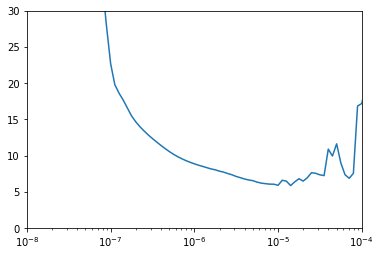

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [9]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
  keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.LSTM(32, return_sequences=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200)
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 1s 96ms/step - loss: 56.9010 - mae: 57.4001 - val_loss: 28.7748 - val_mae: 29.2719
Epoch 2/500
8/8 [==============================] - 0s 16ms/step - loss: 26.1449 - mae: 26.6407 - val_loss: 38.9232 - val_mae: 39.4212
Epoch 3/500
8/8 [==============================] - 0s 15ms/step - loss: 17.3629 - mae: 17.8584 - val_loss: 30.1023 - val_mae: 30.6010
Epoch 4/500
8/8 [==============================] - 0s 19ms/step - loss: 12.0091 - mae: 12.4990 - val_loss: 24.5628 - val_mae: 25.0602
Epoch 5/500
8/8 [==============================] - 0s 18ms/step - loss: 9.9288 - mae: 10.4167 - val_loss: 18.8857 - val_mae: 19.3824
Epoch 6/500
8/8 [==============================] - 0s 19ms/step - loss: 8.8391 - mae: 9.3253 - val_loss: 16.0114 - val_mae: 16.5063
Epoch 7/500
8/8 [==============================] - 0s 18ms/step - loss: 8.0840 - mae: 8.5699 - val_loss: 12.5160 - val_mae: 13.0055
Epoch 8/500
8/8 [==============================] - 0s 19ms/step - l

In [10]:
model = keras.models.load_model("my_checkpoint.h5")

In [11]:
rnn_forecast = model_forecast(model, series[:, np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

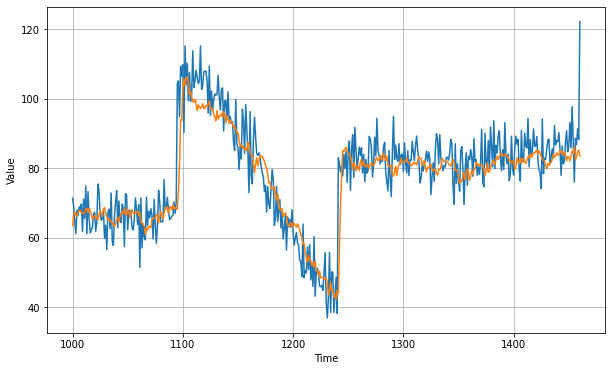

In [12]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [13]:
keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.1123676

# Fully Conv Forecasting similar to Wavenet Architechture

In [14]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))

for dilation_rate in (1, 2, 4, 8, 16, 32):
  model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          activation='relu',
                          padding='causal')
  )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 18ms/step - loss: 42.2341 - mae: 42.7330
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 41.8293 - mae: 42.3284
Epoch 3/100
8/8 [==============================] - 0s 6ms/step - loss: 41.4367 - mae: 41.9357
Epoch 4/100
8/8 [==============================] - 0s 5ms/step - loss: 41.0108 - mae: 41.5098
Epoch 5/100
8/8 [==============================] - 0s 5ms/step - loss: 40.4787 - mae: 40.9776
Epoch 6/100
8/8 [==============================] - 0s 5ms/step - loss: 39.7341 - mae: 40.2328
Epoch 7/100
8/8 [==============================] - 0s 5ms/step - loss: 38.5883 - mae: 39.0871
Epoch 8/100
8/8 [==============================] - 0s 5ms/step - loss: 36.6836 - mae: 37.1822
Epoch 9/100
8/8 [==============================] - 0s 5ms/step - loss: 33.3644 - mae: 33.8629
Epoch 10/100
8/8 [==============================] - 0s 6ms/step - loss: 27.9449 - mae: 28.4427
Epoch 11/100
8/8 [==============================] - 0s 6ms

(0.0001, 0.1, 0.0, 30.0)

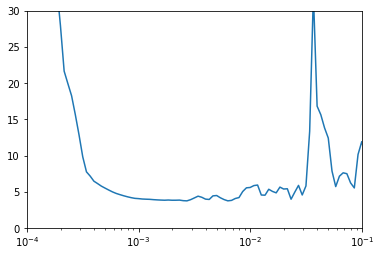

In [15]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [16]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size,
                                   batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )
model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
optimizer = keras.optimizers.Adam(lr=1e-3)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
history = model.fit(train_set, epochs=500,
                    validation_data=valid_set,
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 1s 63ms/step - loss: 38.1011 - mae: 38.5999 - val_loss: 60.1228 - val_mae: 60.6228
Epoch 2/500
8/8 [==============================] - 0s 21ms/step - loss: 26.1971 - mae: 26.6942 - val_loss: 32.6347 - val_mae: 33.1322
Epoch 3/500
8/8 [==============================] - 0s 22ms/step - loss: 19.9024 - mae: 20.3975 - val_loss: 29.0738 - val_mae: 29.5706
Epoch 4/500
8/8 [==============================] - 0s 21ms/step - loss: 15.6854 - mae: 16.1783 - val_loss: 22.9364 - val_mae: 23.4307
Epoch 5/500
8/8 [==============================] - 0s 20ms/step - loss: 11.8881 - mae: 12.3773 - val_loss: 13.1141 - val_mae: 13.6019
Epoch 6/500
8/8 [==============================] - 0s 21ms/step - loss: 8.4041 - mae: 8.8893 - val_loss: 9.7502 - val_mae: 10.2356
Epoch 7/500
8/8 [==============================] - 0s 20ms/step - loss: 7.1158 - mae: 7.6006 - val_loss: 8.3143 - val_mae: 8.7998
Epoch 8/500
8/8 [==============================] - 0s 19ms/step - los

In [17]:
model = keras.models.load_model("my_checkpoint.h5")

In [18]:
cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
cnn_forecast = cnn_forecast[split_time - window_size:-1, -1, 0]

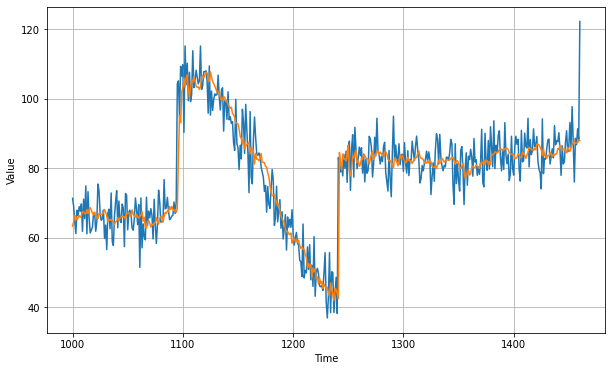

In [19]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, cnn_forecast)

In [20]:
keras.metrics.mean_absolute_error(x_valid, cnn_forecast).numpy()

4.5655437